In [2]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import os
import json
from os.path import exists
import piecewise_regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
# import pysal as ps
# from pysal.contrib.viz import mapping as maps
from shapely import wkt
from shapely.geometry import Polygon
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# get data
dfs = [] # an empty list to store the data frames`
StartDir = '/Users/philipp/BPLA Dropbox/03 Planning/DN-Dumping Detection-1087/05_Output/Digitisation/Version-3/DD-lowest/boundary-reviewed'

json_pattern = os.path.join(StartDir,'*.geojson')
file_list = glob.glob(json_pattern)
print(len(file_list))

for file in file_list:
    data = gpd.read_file(file, lines=True) # read data frame from json file
    dfs.append(data) # append the data frame to the list

# concatenate and format
piles = pd.concat(dfs)
piles=piles.to_crs("EPSG:32638")
piles['str_geom'] = piles['geometry'].apply(wkt.dumps)
piles['FIDint'] = piles['fid'].astype('int64')
len(piles)

1


6311

In [4]:
# filter NA's for the cut
piles = piles[(piles.Updat_cut != 'NA')]
len(piles)
piles['Updat_cut'] = piles['Updat_cut'].astype('float64')
piles['Updat_Volu'] = piles['Updat_Volu'].astype('float64')

pilesNoNA = piles[(~piles['Updat_cut'].isnull())]

len(pilesNoNA)
pilesNoNA['Type'].value_counts()

#piles.to_file(StartDir+"/piles-west-lowest.shp")

# filter for duplicate geometry
pilesNoNA['str_geom_d'] = pilesNoNA.duplicated(subset=['str_geom'], keep=False)
pilesNoNA['str_geom_d'].value_counts()

# unique polygons
pilesNoNANoDup = pilesNoNA[pilesNoNA.str_geom_d == False]
len(pilesNoNANoDup)

pilesNoNADup = pilesNoNA[pilesNoNA.str_geom_d == True]
len(pilesNoNADup)
len(pilesNoNADup.str_geom.unique().tolist())

pilesNoNADupMax = pilesNoNADup.groupby('str_geom', group_keys=False).agg(max)
len(pilesNoNADupMax)

pilesNoNANoDupMax = pilesNoNADup[pilesNoNADup['Updat_cut'].isin(list(pilesNoNADupMax['Updat_cut']))]
len(pilesNoNANoDupMax)

final = pilesNoNANoDup.append(pilesNoNANoDupMax)

/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_77596/667274437.py:26: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  pilesNoNADupMax = pilesNoNADup.groupby('str_geom', group_keys=False).agg(max)
/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_77596/667274437.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = pilesNoNANoDup.append(pilesNoNANoDupMax)


In [5]:
final['Type'] = final['Type'].str.lower()
final['finalcut'] = final.duplicated(subset=['Updat_cut'], keep='first')
final = final[final.finalcut == False]

In [6]:
final['perimeter'] = final['geometry'].to_crs("EPSG:32638").map(lambda p: p.length)
final['area']=final['geometry'].to_crs("EPSG:32638").map(lambda p: p.area)
final['ratio']=final['Updat_cut'].divide(final['area'])

In [7]:
# final['area'].describe()

In [8]:
# output
print(len(final))
print(final['Type'].value_counts())

5885
natural_soil          4072
construction_waste    1439
misc                   374
Name: Type, dtype: int64


In [9]:
print(final.groupby('Type',group_keys=False).agg(sum)['area'])

Type
construction_waste    123266.562013
misc                   35876.129291
natural_soil          361357.204522
Name: area, dtype: float64


/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_77596/1709044387.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(final.groupby('Type',group_keys=False).agg(sum)['area'])


In [10]:
print(final.groupby('Type', group_keys=False).agg(sum)['cut'])
# print(final.groupby('Type',group_keys=False).agg(sum)['volume'])

Type
construction_waste    177843.475501
misc                   35699.619853
natural_soil          478745.455629
Name: cut, dtype: float64


/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_77596/85746032.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(final.groupby('Type', group_keys=False).agg(sum)['cut'])


In [74]:
x = final['area']
y = final['Updat_cut']
x1 = final['ratio']
data = list(zip(x, y))

In [78]:
final.shape

(5885, 19)

In [79]:
len(data)

5885

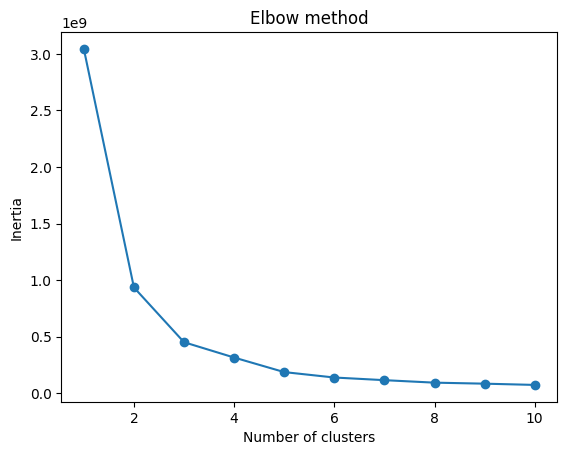

In [80]:
# cluster based om area and volume
from sklearn.cluster import KMeans

inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

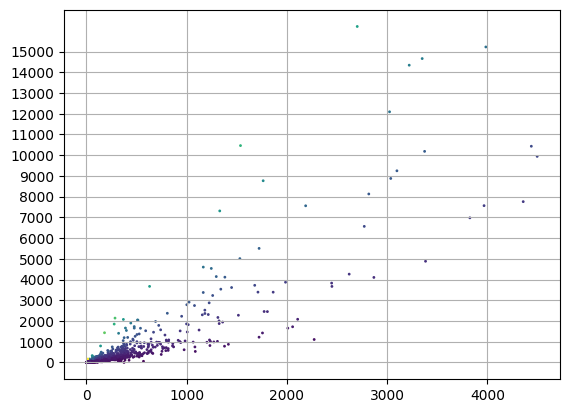

In [81]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(x, y, c=final['ratio'],s=1)
plt.grid(True)
plt.yticks(np.arange(0,16000,1000))
plt.show()

(array([5.900e+01, 2.000e+02, 3.660e+02, 7.230e+02, 1.205e+03, 1.302e+03,
        7.580e+02, 3.940e+02, 2.140e+02, 1.290e+02, 9.300e+01, 8.000e+01,
        4.900e+01, 4.800e+01, 2.700e+01, 3.900e+01, 3.400e+01, 2.200e+01,
        2.100e+01, 1.100e+01, 1.700e+01, 9.000e+00, 8.000e+00, 7.000e+00,
        6.000e+00, 8.000e+00, 4.000e+00, 8.000e+00, 6.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

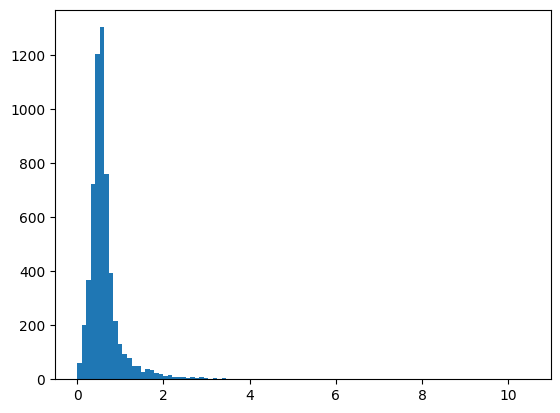

In [14]:
plt.hist(final['ratio'], 100)

In [15]:
print(kmeans)

df = pd.DataFrame(data)
df['cluster'] = kmeans.labels_

KMeans(n_clusters=2)


In [82]:
cluster0 = df[(df["cluster"] == 0)]
cluster1 = df[(df["cluster"] == 1)]  # This is what you want
# cluster2 = df[(df["cluster"] == 1)]  # This is what you want

In [83]:
# data0=final[final['ratio']<2]
# regClu0 = LinearRegression(fit_intercept=True).fit(data0['area'].array.reshape(-1, 1),data0['Updat_cut'].array.reshape(-1, 1))

In [84]:
# data1=final[final['ratio']>=2]
# regClu0 = LinearRegression(fit_intercept=True).fit(data1['area'].array.reshape(-1, 1),data1['Updat_cut'].array.reshape(-1, 1))

In [85]:
regClu0 = LinearRegression(fit_intercept=False).fit(cluster0[[0]],cluster0[[1]])
regClu1 = LinearRegression(fit_intercept=True).fit(cluster1[[0]],cluster1[[1]])
# regClu2 = LinearRegression(fit_intercept=False).fit(cluster2[[0]],cluster2[[1]])

In [86]:
# data0['area'].describe()

In [19]:
# data1['area'].describe()

In [20]:
# The coefficients
print("Coefficients: \n", regClu0.coef_)

Coefficients: 
 [[1.40571804]]


In [97]:
#LReg on small data sets only
toP = gpd.read_file('/Users/philipp/BPLA Dropbox/03 Planning/DN-Dumping Detection-1087/05_Output/Digitisation/Version-4-Worldview3/Final_New_Sat/Final_New_sat-v2-clipped-v2.geojson', lines=True)
toP = toP.to_crs("EPSG:32638")

toP['Type'] = toP['Type'].str.lower()
toP['area'] = toP['geometry'].map(lambda p: p.area)

4495.492609625731

2867.6780757275133

In [109]:
toP.shape

1331.2048507232307

In [112]:
#  predictions
toP0 = toP.loc[toP['area'] < float(cluster1[0].min())].copy()
# toP0 = toP.copy()
# toP0 = toP.loc[toP['ratio'] <2]
print(toP0.shape)

c0_pred = regClu0.predict(np.array(toP0['area']).reshape(-1, 1))
toP0['pred'] = c0_pred
# The coefficients
print("Coefficients: \n", regClu0.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(toP0['area'], c0_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(toP0['area'], c0_pred))

(15258, 4)
Coefficients: 
 [[1.40571804]]
Mean squared error: 581.42
Coefficient of determination: 0.72


In [113]:
toP1 = toP.loc[toP['area'] >= toP0['area'].max()].copy()
# toP1 = toP1.loc[toP1['area'] < float(cluster2[0].max())]
print(toP1.shape)
c1_pred = regClu1.predict(np.array(toP1['area']).reshape(-1, 1))
toP1['pred'] = c1_pred
# The coefficients
print("Coefficients: \n", regClu1.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(toP1['area'], c1_pred))
# # The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(toP1['area'], c1_pred))


# toP2 = toP.loc[toP['area'] > float(cluster2[0].max())]

(4, 4)
Coefficients: 
 [[0.88994402]]
Mean squared error: 43541759.14
Coefficient of determination: -177.79


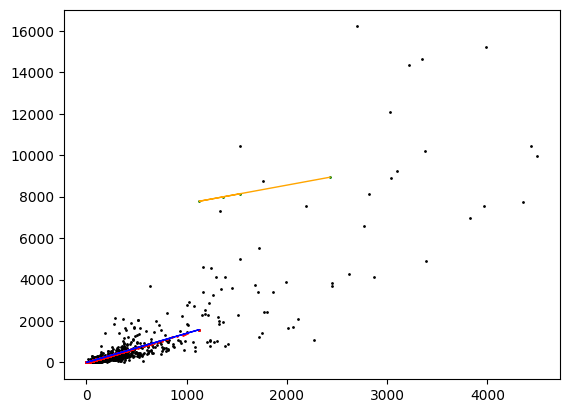

In [116]:
c0_pred.shape= (-1,1)

plt.scatter(x, y, color="black",s=1)
plt.scatter(toP0['area'], c0_pred, color="red",s=1)
plt.scatter(toP1['area'], c1_pred, color="green",s=1)
plt.plot(toP0['area'], c0_pred, color="blue", linewidth=1)
plt.plot(toP1['area'], c1_pred, color="orange", linewidth=1)

plt.show()

In [117]:
# c2_pred = regClu2.predict(np.array(toP2['area']).reshape(-1, 1))
# toP2['pred'] = c2_pred
#
# # The coefficients
# print("Coefficients: \n", regClu2.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(toP2['area'], c2_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(toP2['area'], c2_pred))

In [118]:
# global prediction
# toP = toP[toP['area'] <= float(cluster0[[0]].max())]
# c_pred = regClu0.predict(np.array(toP['area']).reshape(-1, 1))
# toP['pred'] = c_pred
# print(toP.shape)
# # The coefficients
# print("Coefficients: \n", regClu0.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(toP['area'], c_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(toP['area'], c_pred))

In [119]:
predicted = toP0.append(toP1)

/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_77596/3588741542.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predicted = toP0.append(toP1)


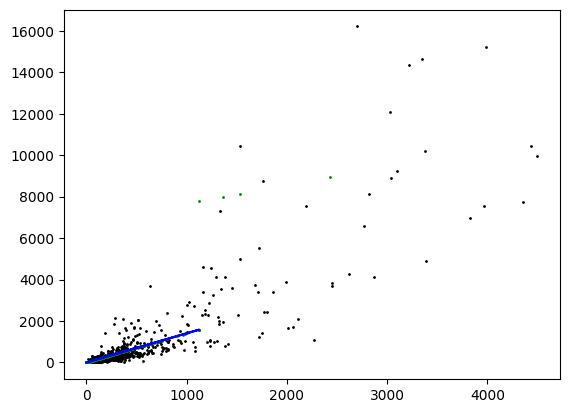

In [120]:
# # # Plot outputs
# # c0_pred.shape= (-1,1)
#
# plt.scatter(x, y, color="black",s=1)
# plt.scatter(predicted['area'],predicted['pred'],color="green",s=1)
# # plt.scatter(toP['area'], c_pred, color="red",s=1)
# plt.plot(toP0['area'], c0_pred, color="blue", linewidth=1.5)
# # plt.plot(toP1['area'], c1_pred, color="red", linewidth=1.5)
# # plt.plot(toP2['area'], c2_pred, color="green", linewidth=1)
#
# plt.show()

In [26]:
# predicted

In [121]:
# output
print(predicted.groupby('Type',group_keys=False).agg(sum)['pred'])
print(predicted.groupby('Type',group_keys=False).agg(sum)['area'])
print(predicted.groupby('Type',group_keys=False).count())
# print(toP)

Type
construction_waste    396004.806556
misc                    9028.577518
natural_soil          449848.532514
Name: pred, dtype: float64
Type
construction_waste    269118.102925
misc                    6422.751414
natural_soil          315691.935243
Name: area, dtype: float64
                    OBJECTID  geometry  area  pred
Type                                              
construction_waste      6516      6594  6594  6594
misc                     142       142   142   142
natural_soil            8493      8526  8526  8526


/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_77596/2288747426.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(predicted.groupby('Type',group_keys=False).agg(sum)['pred'])
/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_77596/2288747426.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(predicted.groupby('Type',group_keys=False).agg(sum)['area'])


In [122]:
predicted['ratio']=predicted['pred'].divide(predicted['area'])
predicted['ratio'].describe()

count    15262.000000
mean         1.406775
std          0.067965
min          1.405718
25%          1.405718
50%          1.405718
75%          1.405718
max          6.903935
Name: ratio, dtype: float64

In [37]:
final

,fid,cat,Id,Type,cut,fill,volume,str_geom,FIDint,str_geom_d,finalcut,area,ratio,y_pred,Updat_area,Updat_cut,Updat_Volu,geometry,perimeter
0,64.0,200.0,0.0,construction_waste,19.358050,0.0,19.35805046099543,MULTIPOLYGON (((661855.1470344772096723 271591...,64,False,False,33.310999,0.581131,NaN,33.316,19.361,19.361,"MULTIPOLYGON (((661855.147 2715910.261, 661857...",23.550303
1,65.0,201.0,0.0,construction_waste,66.750949,-0.060730561379273844,66.69021831203122,MULTIPOLYGON (((661701.0498651723610237 271612...,65,False,False,120.712029,0.552977,NaN,120.731,66.761,66.701,"MULTIPOLYGON (((661701.050 2716126.487, 661702...",61.780554
2,80.0,219.0,0.0,construction_waste,9.967514,-0.00010354714871778371,9.967410268149333,MULTIPOLYGON (((661796.5084588918834925 271601...,80,False,False,19.515538,0.510748,NaN,19.519,9.969,9.969,"MULTIPOLYGON (((661796.508 2716016.998, 661800...",17.975159
3,81.0,221.0,0.0,construction_waste,15.919302,-0.0061824381122978648,15.91311960942508,MULTIPOLYGON (((661849.6607110316399485 271601...,81,False,False,26.614882,0.598135,NaN,26.619,15.922,15.916,"MULTIPOLYGON (((661849.661 2716019.832, 661851...",20.067042
4,82.0,223.0,0.0,construction_waste,47.029063,-0.0040382707231438296,47.02502441618826,MULTIPOLYGON (((661717.0828087122645229 271613...,82,False,False,111.620967,0.421328,NaN,111.638,47.036,47.032,"MULTIPOLYGON (((661717.083 2716133.185, 661740...",58.852991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6310,3852.0,NaN,NaN,construction_waste,8.872994,None,None,MULTIPOLYGON (((665774.1511404308257625 271610...,3852,False,False,18.386815,0.482574,8.872994,18.389,8.874,NaN,"MULTIPOLYGON (((665774.151 2716108.553, 665772...",16.170456
2366,3184.0,NaN,NaN,construction_waste,30.016684,0.0,30.01668412465427,MULTIPOLYGON (((665165.8318939859746024 271561...,3184,True,False,34.961163,0.858572,NaN,34.966,30.021,30.021,"MULTIPOLYGON (((665165.832 2715617.476, 665165...",22.130684
2367,3187.0,NaN,NaN,natural_soil,35.543250,0.0,35.5432499971223,MULTIPOLYGON (((665133.4313261091010645 271560...,3187,True,False,35.380907,1.004588,NaN,35.385,35.547,35.547,"MULTIPOLYGON (((665133.431 2715608.087, 665135...",22.636426
2368,3813.0,NaN,NaN,construction_waste,5.037203,0.0,5.037203342522038,MULTIPOLYGON (((665140.2116184852784500 271560...,3813,True,False,11.824106,0.426011,NaN,11.826,5.038,5.038,"MULTIPOLYGON (((665140.212 2715608.555, 665138...",13.393251


In [29]:
predEx = predicted.explode()
finalEx = final.explode()

/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_82622/548489403.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  predEx = predicted.explode()
/var/folders/zm/fb_kfkpj55zf4d6ywxmphdy40000gn/T/ipykernel_82622/548489403.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  finalEx = final.explode()


In [30]:
r = (finalEx.geometry.type == 'Polygon')
r.value_counts()
# finalEx.shape

True    5891
dtype: int64

In [ ]:
# area difference
## additions in 2022
notinFinals = gpd.overlay(finalEx,predEx, how='difference')
notinFinals['area']=notinFinals['geometry'].to_crs("EPSG:32638").map(lambda p: p.area)
print(notinFinals.groupby('Type',group_keys=False).agg(sum)['area'])

In [36]:
notinFinals.to_file('additions-2022.shp')

In [ ]:
## Removals in 2022
notintoP = gpd.overlay(predEx,finalEx, how='difference')
notintoP['area']=notintoP['geometry'].to_crs("EPSG:32638").map(lambda p: p.area)
print(notintoP.groupby('Type',group_keys=False).agg(sum)['area'])

In [37]:
notintoP.to_file('removal-2022.shp')

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import leastsq
#
# #x, y = np.array([0,1,2,3,4,5]), np.array([0,1,4,9,16,25])
#
# # initial_guess[i] maps to p[x] in function_to_fit, must be reasonable
# initial_guess = [1, 1, 1]
#
# def function_to_fit(x, p):
#     return pow(p[0]*x, 2) + p[1]*x + p[2]
#
# def residuals(p,y,x):
#     return y - function_to_fit(x,p)
#
# cnsts = leastsq(
#     residuals,
#     initial_guess,
#     args=(y, x)
# )[0]
#
# fig, ax = plt.subplots()
# ax.plot(x, y, 'o')
#
# xi = np.arange(0,100,10)
# ax.plot(xi, [function_to_fit(x, cnsts) for x in xi])
#
# plt.show()